In [1]:
library(Seurat)
library(dplyr)
library(sctransform)
library(ggplot2)

# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/mnt/e/MPIMG/Rotation/elkabetz/scrna/seurat_inputs/sbn_sbnx_nt/")

# Examine the memory savings between regular and sparse matrices
dense.size <- object.size(x = as.matrix(x = pbmc.data))
dense.size
sparse.size <- object.size(x = pbmc.data)
sparse.size


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



1022840552 bytes

125621960 bytes

In [17]:
data_mat <- as.matrix(pbmc.data)
dim(data_mat)

[1] 14219  8978

In [18]:
write.csv(data_mat,"/mnt/e/MPIMG/Elkabetz/data/scrna/d50_organoids/sbn_sbnx_nt.gene_matrix.csv")

In [ ]:
# Initialize the Seurat object with the raw (non-normalized data).  Keep all
# genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at
# least 200 detected genes
pbmc <- CreateSeuratObject(raw.data = pbmc.data, min.cells = 3, min.genes = 200, 
    project = "allcombined")

In [4]:
length(pbmc@cell.names)

[1] 8978

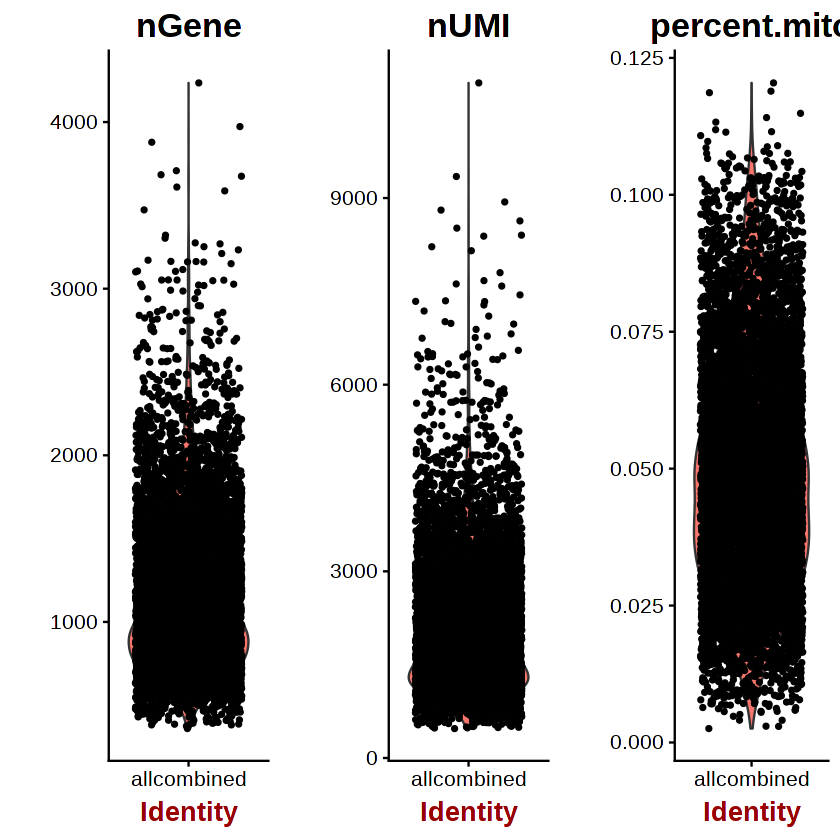

In [5]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated
# for every object by Seurat.  For non-UMI data, nUMI represents the sum of
# the non-normalized values within a cell We calculate the percentage of
# mitochondrial genes here and store it in percent.mito using AddMetaData.
# We use object@raw.data since this represents non-transformed and
# non-log-normalized counts The % of UMI mapping to MT-genes is a common
# scRNA-seq QC metric.

# remove RP1, RP11, RP3, RP4, RP5, RP6 genes?  start with rp11 for now

mito.genes <- grep(pattern = "^MT.", x = rownames(x = pbmc@data), value = TRUE)
percent.mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ])/Matrix::colSums(pbmc@raw.data)
rp11.genes <- grep(pattern = "^RP11.", x = rownames(x = pbmc@data), value = TRUE)
percent.rp11 <- Matrix::colSums(pbmc@raw.data[rp11.genes, ])/Matrix::colSums(pbmc@raw.data)
rp1.genes <- grep(pattern = "^RP1.", x = rownames(x = pbmc@data), value = TRUE)
percent.rp1 <- Matrix::colSums(pbmc@raw.data[rp1.genes, ])/Matrix::colSums(pbmc@raw.data)
rp3.genes <- grep(pattern = "^RP3.", x = rownames(x = pbmc@data), value = TRUE)
percent.rp3 <- Matrix::colSums(pbmc@raw.data[rp3.genes, ])/Matrix::colSums(pbmc@raw.data)
rp4.genes <- grep(pattern = "^RP4.", x = rownames(x = pbmc@data), value = TRUE)
percent.rp4 <- Matrix::colSums(pbmc@raw.data[rp4.genes, ])/Matrix::colSums(pbmc@raw.data)
rp5.genes <- grep(pattern = "^RP5.", x = rownames(x = pbmc@data), value = TRUE)
percent.rp5 <- Matrix::colSums(pbmc@raw.data[rp5.genes, ])/Matrix::colSums(pbmc@raw.data)
rp6.genes <- grep(pattern = "^RP6.", x = rownames(x = pbmc@data), value = TRUE)
percent.rp6 <- Matrix::colSums(pbmc@raw.data[rp6.genes, ])/Matrix::colSums(pbmc@raw.data)

# AddMetaData adds columns to object@meta.data, and is a great place to
# stash QC stats
pbmc <- AddMetaData(object = pbmc, metadata = percent.mito, col.name = "percent.mito")
pbmc <- AddMetaData(object = pbmc, metadata = percent.rp1, col.name = "percent.rp1")
pbmc <- AddMetaData(object = pbmc, metadata = percent.rp11, col.name = "percent.rp11")
pbmc <- AddMetaData(object = pbmc, metadata = percent.rp3, col.name = "percent.rp3")
pbmc <- AddMetaData(object = pbmc, metadata = percent.rp4, col.name = "percent.rp4")
pbmc <- AddMetaData(object = pbmc, metadata = percent.rp5, col.name = "percent.rp5")
pbmc <- AddMetaData(object = pbmc, metadata = percent.rp6, col.name = "percent.rp6")
VlnPlot(object = pbmc, features.plot = c("nGene", "nUMI", "percent.mito"), nCol = 3)

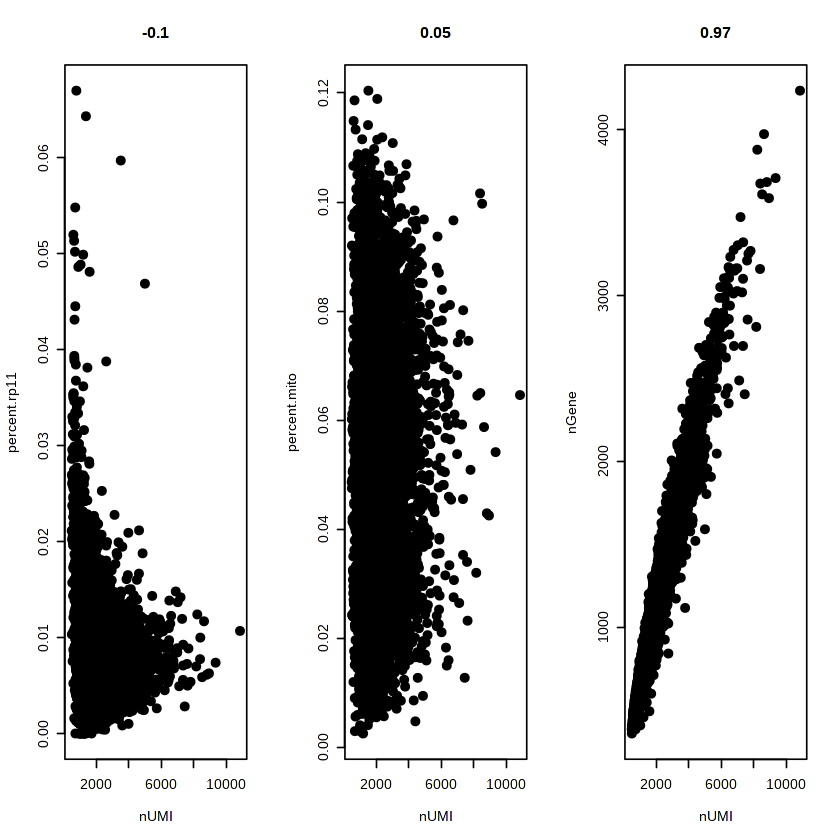

In [6]:
# GenePlot is typically used to visualize gene-gene relationships, but can
# be used for anything calculated by the object, i.e. columns in
# object@meta.data, PC scores etc.  Since there is a rare subset of cells
# with an outlier level of high mitochondrial percentage and also low UMI
# content, we filter these as well
par(mfrow = c(1, 3))
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "percent.rp11")
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "percent.mito")
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "nGene")

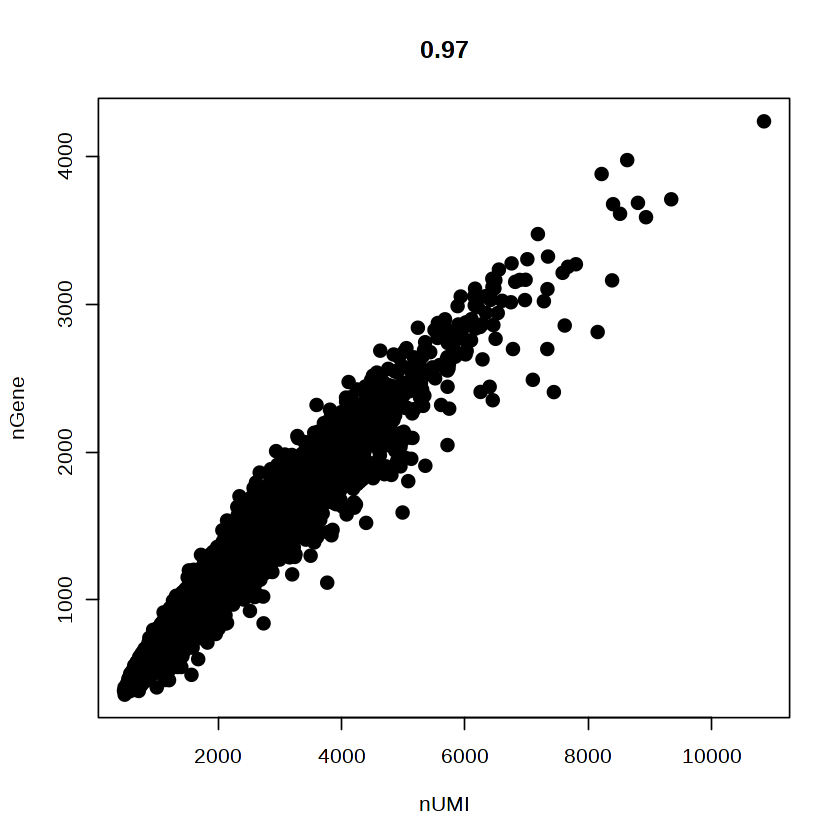

In [7]:
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "nGene")

In [8]:
# We filter out cells that have unique gene counts over 2,500 or less than
# 200 Note that low.thresholds and high.thresholds are used to define a
# 'gate'.  -Inf and Inf should be used if you don't want a lower or upper
# threshold.
pbmc <- FilterCells(object = pbmc, subset.names = c("nGene", "percent.mito"),low.thresholds = c(200, -Inf))#, high.thresholds = c(2500, 0.05))

In [9]:
pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", 
    scale.factor = 10000)

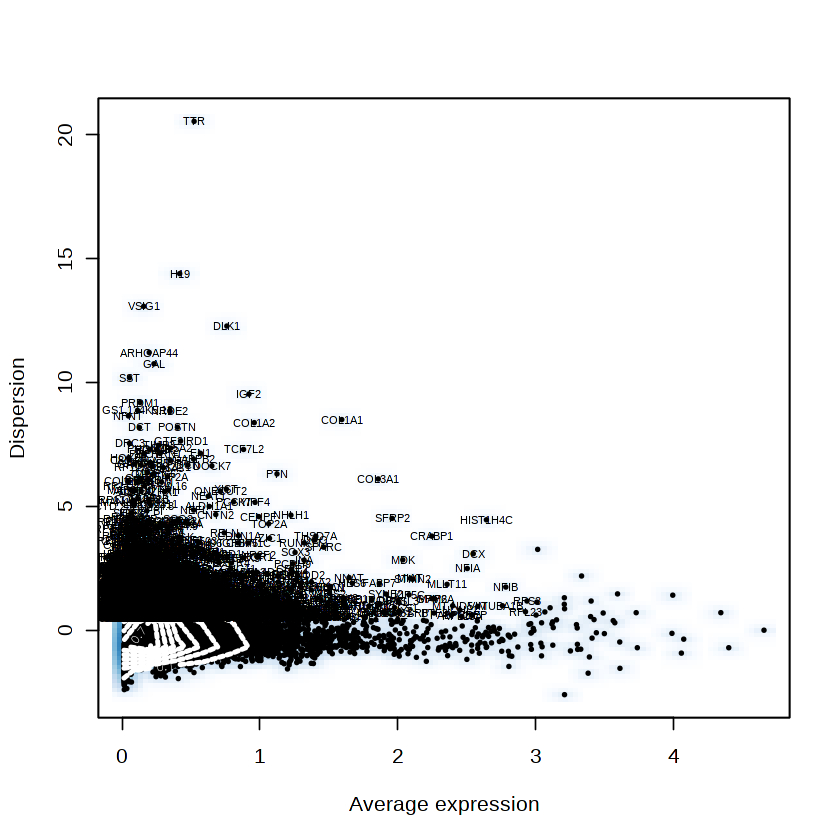

In [10]:
pbmc <- FindVariableGenes(object = pbmc, mean.function = ExpMean, dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)

In [11]:
length(x = pbmc@var.genes)

[1] 2868

In [12]:
length(x = pbmc@cell.names)

[1] 8978

In [14]:
pbmc <- ScaleData(object = pbmc, vars.to.regress = c("nUMI", "percent.mito"))

Regressing out: nUMI, percent.mito



Time Elapsed:  27.7611536979675 secs

Scaling data matrix


In [37]:
length(pbmc@var.genes)

[1] 2868

In [15]:
pbmc <- RunPCA(object = pbmc, pc.genes = pbmc@var.genes, do.print = TRUE, pcs.print = 1:5, genes.print = 5)

[1] "PC1"
[1] "DCX"     "MAP2"    "NFIB"    "NEUROD6" "STMN2"  
[1] ""
[1] "MDK"    "SFRP2"  "VIM"    "SPARC"  "CRABP1"
[1] ""
[1] ""
[1] "PC2"
[1] "CRABP1" "COL3A1" "COL1A1" "SFRP2"  "COL1A2"
[1] ""
[1] "FABP7"   "SOX3"    "SYNE2"   "C1orf61" "SFRP1"  
[1] ""
[1] ""
[1] "PC3"
[1] "CRABP1" "SFRP2"  "DAPL1"  "RAB31"  "RORB"  
[1] ""
[1] "COL1A2" "LUM"    "DCN"    "COL1A1" "COL5A2"
[1] ""
[1] ""
[1] "PC4"
[1] "NEUROD6" "NFIA"    "NFIB"    "TBR1"    "BCL11B" 
[1] ""
[1] "ZIC1"   "NEFL"   "PBX3"   "ZNF503" "NR2F2" 
[1] ""
[1] ""
[1] "PC5"
[1] "NHLH1" "DLL3"  "EOMES" "CNTN2" "RND3" 
[1] ""
[1] "MKI67"   "TOP2A"   "CENPF"   "UBE2C"   "CNTNAP2"
[1] ""
[1] ""


In [16]:
# Examine and visualize PCA results a few different ways
PrintPCA(object = pbmc, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

[1] "PC1"
[1] "DCX"     "MAP2"    "NFIB"    "NEUROD6" "STMN2"  
[1] ""
[1] "MDK"    "SFRP2"  "VIM"    "SPARC"  "CRABP1"
[1] ""
[1] ""
[1] "PC2"
[1] "CRABP1" "COL3A1" "COL1A1" "SFRP2"  "COL1A2"
[1] ""
[1] "FABP7"   "SOX3"    "SYNE2"   "C1orf61" "SFRP1"  
[1] ""
[1] ""
[1] "PC3"
[1] "CRABP1" "SFRP2"  "DAPL1"  "RAB31"  "RORB"  
[1] ""
[1] "COL1A2" "LUM"    "DCN"    "COL1A1" "COL5A2"
[1] ""
[1] ""
[1] "PC4"
[1] "NEUROD6" "NFIA"    "NFIB"    "TBR1"    "BCL11B" 
[1] ""
[1] "ZIC1"   "NEFL"   "PBX3"   "ZNF503" "NR2F2" 
[1] ""
[1] ""
[1] "PC5"
[1] "NHLH1" "DLL3"  "EOMES" "CNTN2" "RND3" 
[1] ""
[1] "MKI67"   "TOP2A"   "CENPF"   "UBE2C"   "CNTNAP2"
[1] ""
[1] ""


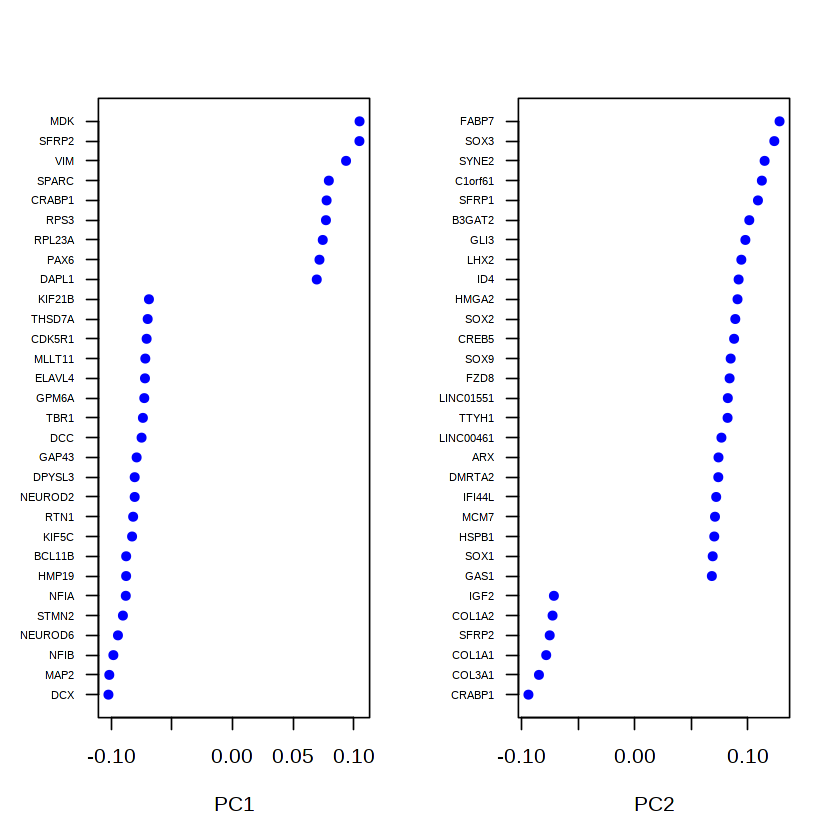

In [17]:
VizPCA(object = pbmc, pcs.use = 1:2)

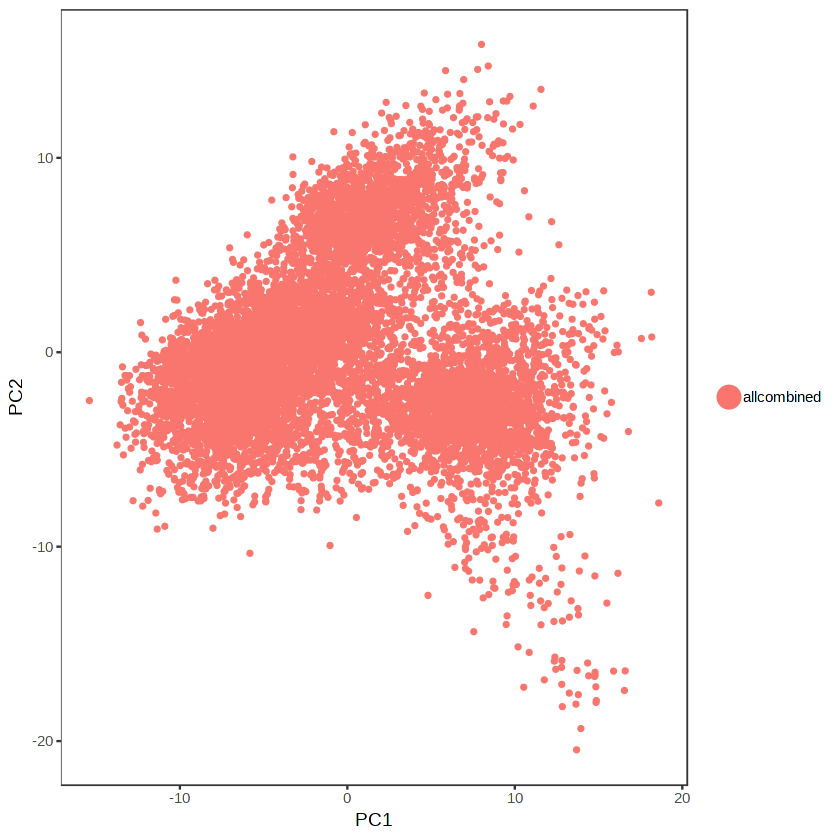

In [18]:
PCAPlot(object = pbmc, dim.1 = 1, dim.2 = 2)

In [19]:
# ProjectPCA scores each gene in the dataset (including genes not included
# in the PCA) based on their correlation with the calculated components.
# Though we don't use this further here, it can be used to identify markers
# that are strongly correlated with cellular heterogeneity, but may not have
# passed through variable gene selection.  The results of the projected PCA
# can be explored by setting use.full=T in the functions above
pbmc <- ProjectPCA(object = pbmc, do.print = FALSE)

Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”Warning message in plot.window(...):
“"dimTitle" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"dimTitle" is not a graphical parameter”Warning message in title(...):
“"dimTitle" is not a graphical parameter”

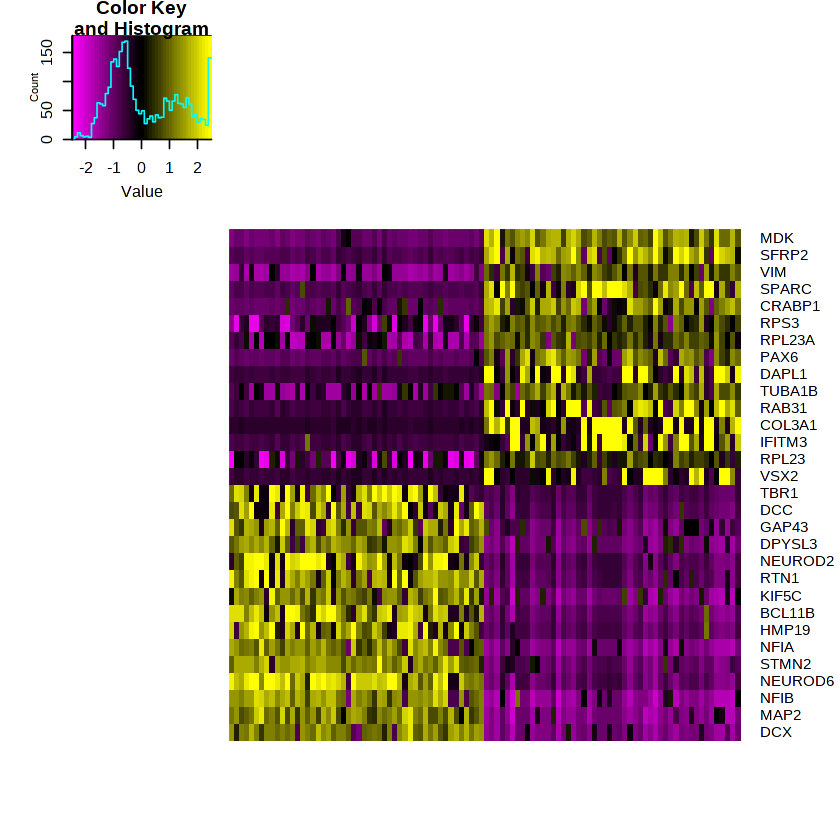

In [20]:
PCHeatmap(object = pbmc, pc.use = 1, cells.use = 100, do.balanced = TRUE, label.columns = FALSE)

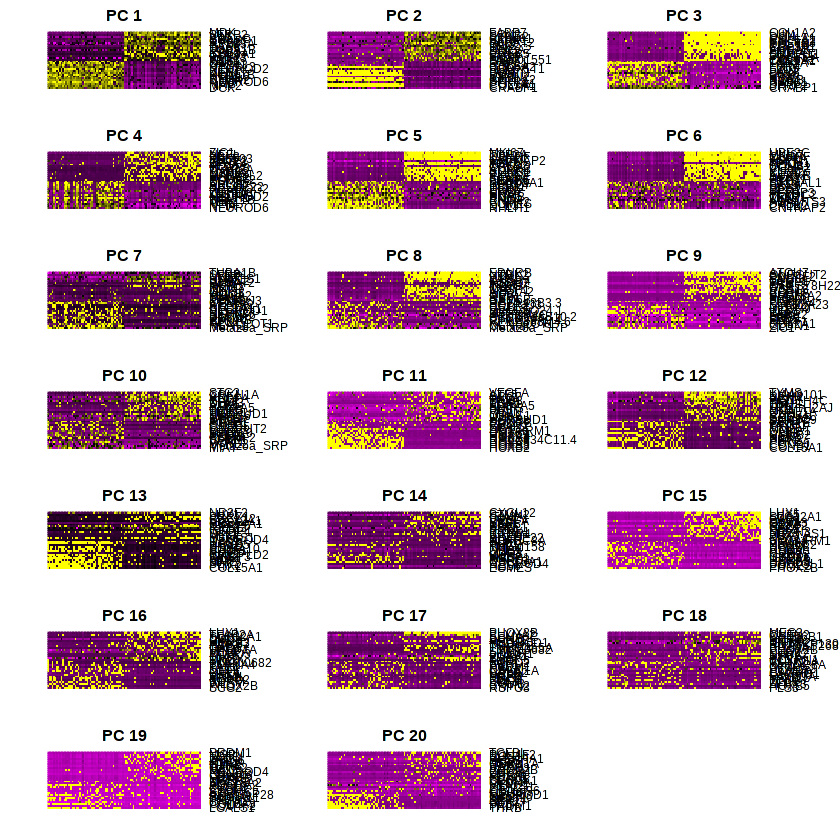

In [21]:
PCHeatmap(object = pbmc, pc.use = 1:20, cells.use = 100, do.balanced = TRUE, 
    label.columns = FALSE, use.full = FALSE)

In [78]:
# NOTE: This process can take a long time for big datasets, comment out for
# expediency.  More approximate techniques such as those implemented in
# PCElbowPlot() can be used to reduce computation time
pbmc <- JackStraw(object = pbmc, num.replicate = 100, display.progress = FALSE)

Warning message:
“Removed 50237 rows containing missing values (geom_point).”

An object of class seurat in project SBNG2 
 11265 genes across 176 samples.

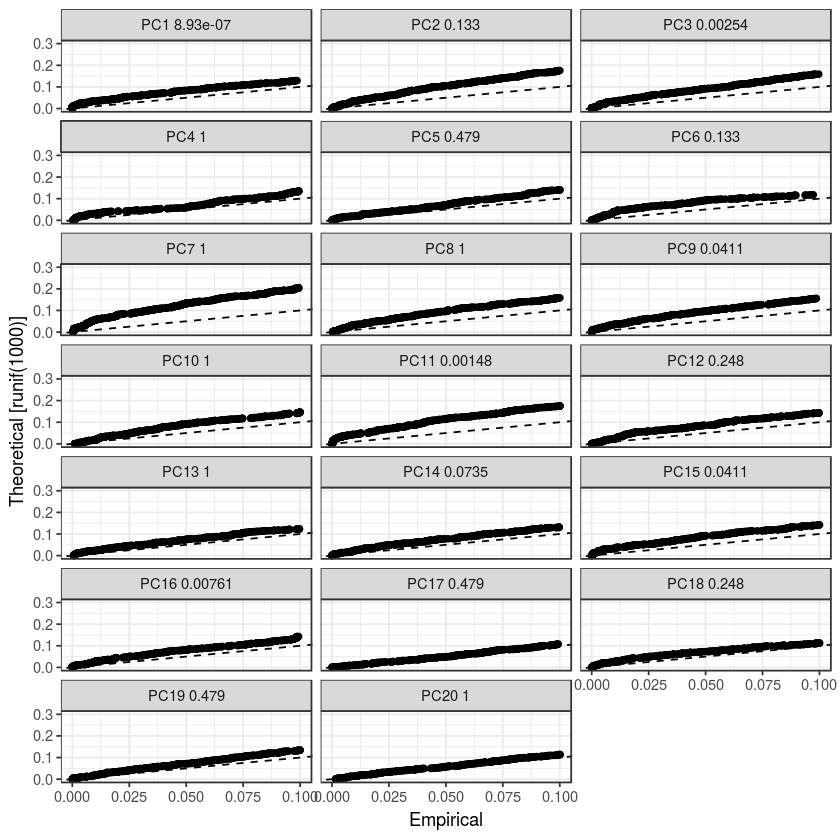

In [74]:
JackStrawPlot(object = pbmc, PCs = 1:20)

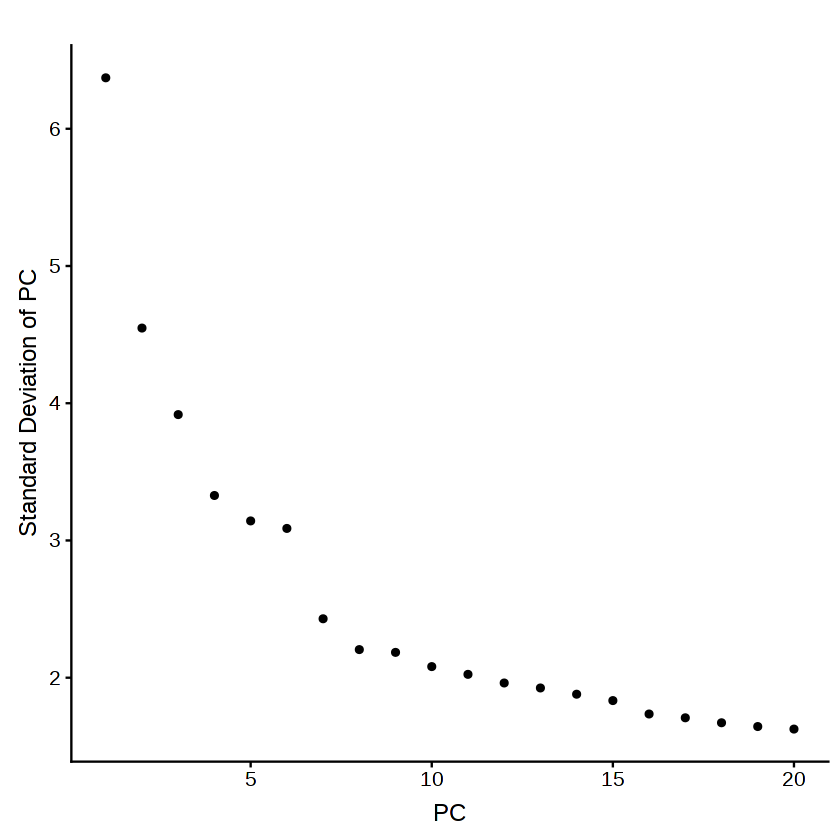

In [22]:
PCElbowPlot(object = pbmc)

In [25]:
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun
# using the same graph but with a different resolution value (see docs for
# full details)
pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:6, 
    resolution = 0.6, print.output = 0, save.SNN = TRUE)

In [26]:
PrintFindClustersParams(object = pbmc)

Parameters used in latest FindClusters calculation run on: 2019-03-27 17:13:55
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          prune.SNN
     pca                 30                0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6



In [27]:
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)

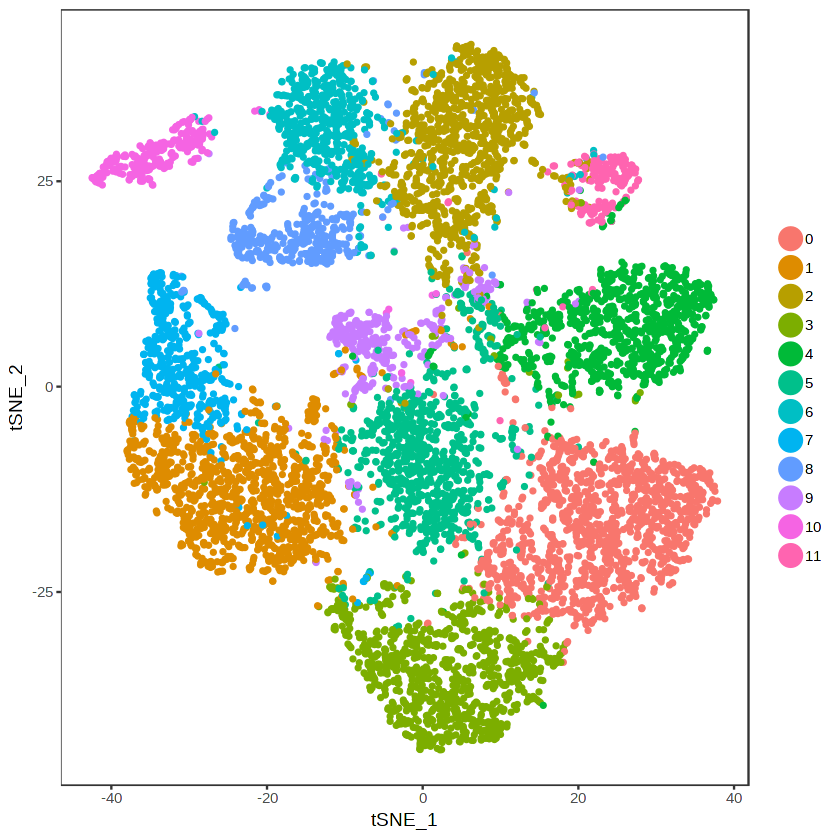

In [28]:
# note that you can set do.label=T to help label individual clusters
TSNEPlot(object = pbmc)

In [29]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_0.8.0.1 Seurat_2.3.4  Matrix_1.2-15 cowplot_0.9.4 ggplot2_3.1.0

loaded via a namespace (and not attached):
  [1] Rtsne_0.15          colorspace_1.4-1    class_7.3-15       
  [4] modeltools_0.2-22   ggridges_0.5.1      mclust_5.4.3       
  [7] IRdisplay_0.7.0     htmlTable_1.13.1    base64enc_0.1-3    
 [10] rstudioa

In [33]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster10.markers <- FindMarkers(object = pbmc, ident.1 = 10, ident.2 = c(0,1,2,3,4,5,6,7,8,9,11,12), 
    min.pct = 0.25)
print(x = head(x = cluster10.markers, n = 50))

                 p_val avg_logFC pct.1 pct.2     p_val_adj
COL3A1    0.000000e+00 3.8981738 0.950 0.112  0.000000e+00
COL1A1    0.000000e+00 3.8511510 0.911 0.095  0.000000e+00
COL1A2    0.000000e+00 3.2735478 0.876 0.049  0.000000e+00
IGF2      0.000000e+00 2.8602721 0.770 0.079  0.000000e+00
DCN       0.000000e+00 2.4510955 0.667 0.031  0.000000e+00
FN1       0.000000e+00 2.4304120 0.656 0.046  0.000000e+00
POSTN     0.000000e+00 2.3763520 0.543 0.019  0.000000e+00
COL5A2    0.000000e+00 2.1909883 0.564 0.016  0.000000e+00
LUM       0.000000e+00 2.1498492 0.521 0.010  0.000000e+00
COL6A3    0.000000e+00 2.0127460 0.550 0.018  0.000000e+00
COL5A1    0.000000e+00 2.0017154 0.589 0.031  0.000000e+00
COL6A2    0.000000e+00 1.5911668 0.528 0.030  0.000000e+00
LGALS1    0.000000e+00 1.4510872 0.362 0.011  0.000000e+00
PDGFRA    0.000000e+00 1.2909875 0.355 0.005  0.000000e+00
S100A11   0.000000e+00 1.2096114 0.326 0.005  0.000000e+00
MMP2     2.209697e-306 1.2092789 0.316 0.009 3.141968e-3

In [ ]:
# find markers for every cluster compared to all remaining cells, report
# only the positive ones
pbmc.markers <- FindAllMarkers(object = pbmc, only.pos = TRUE, min.pct = 0.25, 
    thresh.use = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(10, avg_logFC)

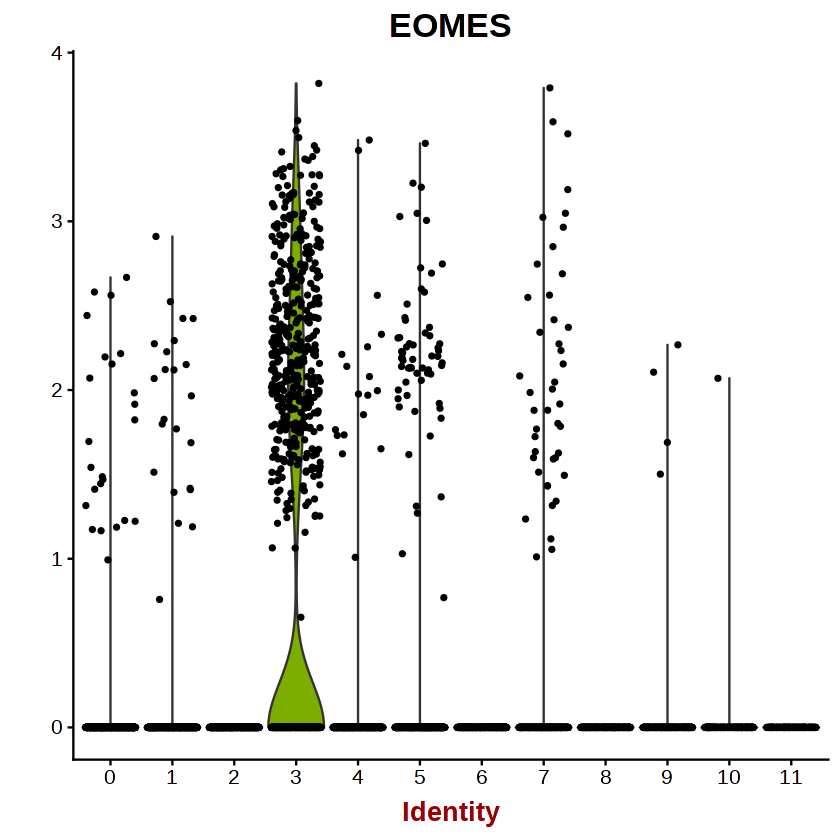

In [27]:
VlnPlot(object = pbmc, features.plot = c("EOMES"))

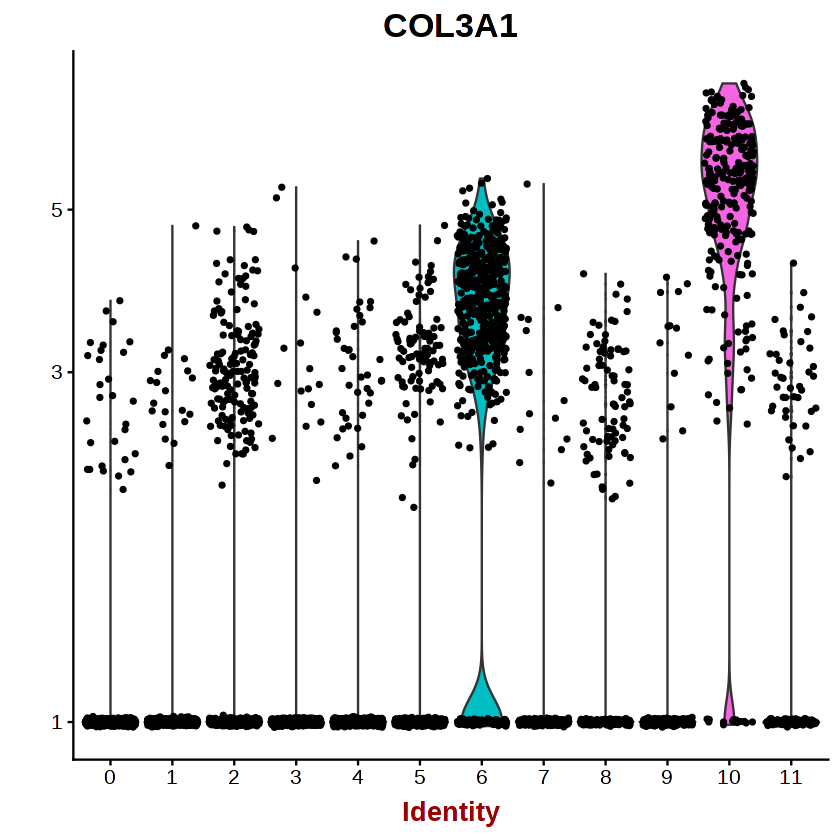

In [28]:
VlnPlot(object = pbmc, features.plot = c("COL3A1"),y.log=TRUE)#use.raw = TRUE)#, y.log = TRUE)

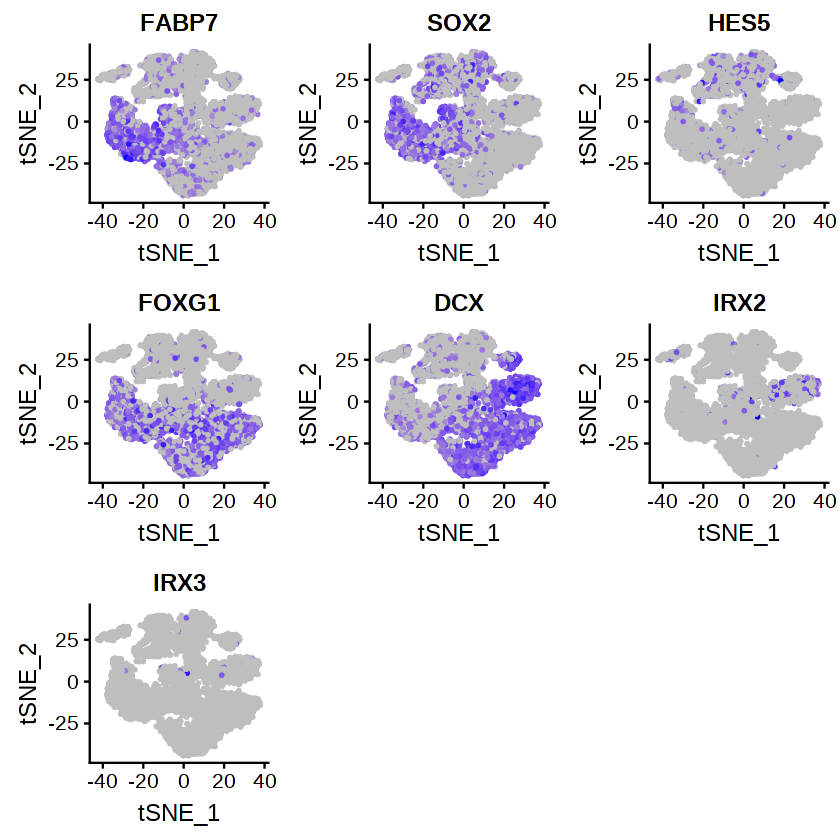

In [29]:
FeaturePlot(object = pbmc, features.plot = c("FABP7","SOX2","HES5","FOXG1","DCX","IRX2","IRX3"), cols.use = c("grey", "blue"), 
    reduction.use = "tsne")

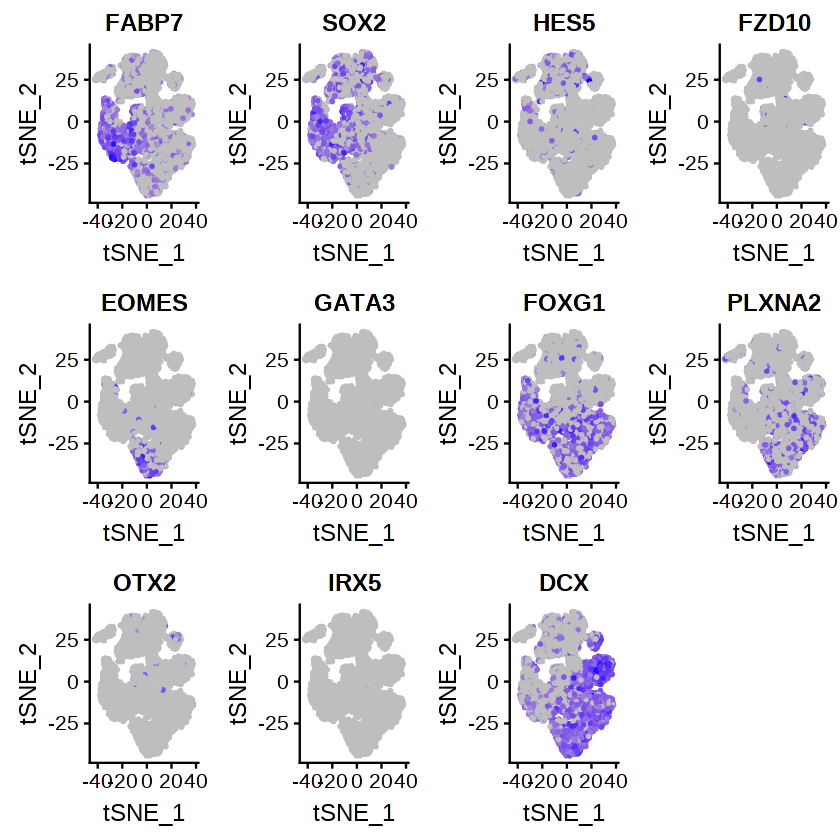

In [30]:
FeaturePlot(object = pbmc, features.plot = c("FABP7","SOX2","HES5","FZD10","EOMES",
                                             "GATA3","FOXG1","PLXNA2","OTX2","IRX5","DCX"), cols.use = c("grey", "blue"), 
    reduction.use = "tsne")

In [33]:
write.csv(pbmc@dr$tsne@cell.embeddings,"Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/tsne.sbnx_sbn_nt.csv")
write.csv(pbmc@dr$pca@cell.embeddings,"Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/pca.sbnx_sbn_nt.csv")
write.csv(pbmc@meta.data,"Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/metadata.sbnx_sbn_nt.csv")
write.csv(pbmc@ident,"Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/clustering.sbnx_sbn_nt.csv")
save(pbmc,file='Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/pbmc.RData')

In [27]:
write.csv(pbmc@ident,"Seurat_runs/merged_sbnx_sbn_nt_all_runs/clustering.check.sbnx_sbn_nt.csv")